# Comment & Guestbook Support Data Selection and Exploration
Selects samples of `n` texts to run support analysis on. Consider all non-spam non-employee users from the beginning of the network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"

In [5]:
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
df = pd.read_hdf(author_to_site)
len(df)

28388948

In [6]:
# load the list of valid users. how to regenerate valid_user_ids.txt to include ALL users?
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "supportive_valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

447260

In [7]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "supportive_valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

411269

In [ ]:
ints = df[(df.user_id.isin(valid_user_ids)) & (df.int_type != "journal") & (~df.is_self_interaction) & (df.is_nontrivial)]
len(ints)

In [ ]:
#comments = ints[ints.int_type == 'comment']
#len(comments)

In [ ]:
#comments_sample = comments.sample(n=100000)

In [10]:
guestbooks = ints[ints.int_type == 'guestbook']
len(guestbooks)

5212040

In [11]:
gb_sample = guestbooks.sample(n=1000000)

In [13]:
# add the guestbook text directly
s = datetime.now()
import sqlite3
try:
    gb_db_filepath = "/home/srivbane/shared/caringbridge/data/projects/caringbridge_core/updated_guestbook.sqlite"
    guestbook_db = sqlite3.connect(
        gb_db_filepath,
        detect_types=sqlite3.PARSE_DECLTYPES
    )
    guestbook_db.row_factory = sqlite3.Row
    
    body_texts = []
    for user_id, site_id, created_at in tqdm(zip(gb_sample.user_id, gb_sample.site_id, gb_sample.created_at), total=1000000, position=False):
        cursor = guestbook_db.execute("""
                    SELECT *
                        FROM guestbook 
                        WHERE user_id = ? AND site_id = ? AND created_at = ?
                    """, (user_id,site_id,created_at))
        result = cursor.fetchall()
        #assert len(result) == 1
        result = result[0]
        body = result['body']
        body_texts.append(body)
finally:
    guestbook_db.close()
assert len(body_texts) == len(gb_sample)
gb_sample['body_text'] = body_texts
print(datetime.now() - s)

100%|██████████| 1000000/1000000 [3:17:28<00:00, 84.40it/s]  


3:17:29.063122


In [ ]:
# add the comment text directly
s = datetime.now()
import sqlite3
try:
    cm_db_filepath = "/home/srivbane/shared/caringbridge/data/projects/caringbridge_core/updated_comments.sqlite"
    comment_db = sqlite3.connect(
        cm_db_filepath,
        detect_types=sqlite3.PARSE_DECLTYPES
    )
    comment_db.row_factory = sqlite3.Row
    
    body_texts = []
    for user_id, site_id, created_at in tqdm(zip(comments_sample.user_id, comments_sample.site_id, comments_sample.created_at), total=100000, position=False):
        cursor = comment_db.execute("""
                    SELECT *
                        FROM comments 
                        WHERE user_id = ? AND site_id = ? AND created_at = ?
                    """, (user_id,site_id,created_at))
        result = cursor.fetchall()
        #assert len(result) == 1
        result = result[0]
        body = result['body']
        body_texts.append(body)
finally:
    comment_db.close()
assert len(body_texts) == len(comments_sample)
comments_sample['body_text'] = body_texts
print(datetime.now() - s)

In [14]:
from html.parser import HTMLParser

# See: https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def handle_starttag(self, tag, attrs):
        if tag == 'br':
            self.fed.append("\n")  # this adds linebreaks in place of <br> tags
    def get_data(self):
        return ''.join(self.fed)


def strip_tags(html_text):  # this function strips HTML tags from a given text string
    s = MLStripper()
    s.feed(html_text)
    return s.get_data()

cleaned_texts = []
for body_text in gb_sample.body_text:
    try:
        cleaned_text = strip_tags(body_text)
        cleaned_texts.append(cleaned_text)
    except TypeError:
        cleaned_texts.append("")
gb_sample['body_text'] = cleaned_texts
#cleaned_texts = []
#for body_text in comments_sample.body_text:
#    cleaned_text = strip_tags(body_text)
#    cleaned_texts.append(cleaned_text)
#comments_sample['body_text'] = cleaned_texts

In [5]:
output_data_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/support_modeling/samples"

In [18]:
gb_sample.to_hdf(os.path.join(output_data_dir, 'gb_sample_1000000_021220.h5'), key='gb_sample', mode='w')

In [22]:
comments_sample.to_hdf(os.path.join(output_data_dir, 'com_sample_10000_20200211.h5'), key='comments', mode='w')

### For Annotation:

In [9]:
gb_sample = pd.read_hdf(os.path.join(output_data_dir, 'gb_sample_1000000_021220.h5'), key='gb_sample')

In [10]:
sample = gb_sample.sample(n=100)

In [11]:
port = 5011
sample['link'] = [f"http://127.0.0.1:{port}/guestbook/siteId/{site_id}" for site_id in sample.site_id]
sample['initiator_relationship_to_site_author'] = ''
sample['support_rating'] = ''
sample['other_comments'] = ''

In [13]:
towrite_df = sample[['user_id', 'site_id', 'link', 'body_text', 'support_rating', 'other_comments']]
sample_filepath = 'support_annotation_022119.csv'
towrite_df.to_csv(sample_filepath, index=False)
print("Finished.")

Finished.


'support_annotation_022119.csv'

### Annotation Analysis

In [6]:
ddf = pd.read_csv("data/drew-annotations.csv")
zdf = pd.read_csv("data/zach-annotations.csv")

In [10]:
d_scores = ddf.support_rating[:100]
z_scores = zdf.support_rating[:100]

In [11]:
from scipy.stats import pearsonr
pearsonr(d_scores, z_scores)

(0.5380886450170286, 7.757887643278645e-09)

In [9]:
d_centered = d_scores - np.mean(d_scores)
z_centered = z_scores - np.mean(z_scores)

Text(0.5, 1.0, 'Centered score frequency')

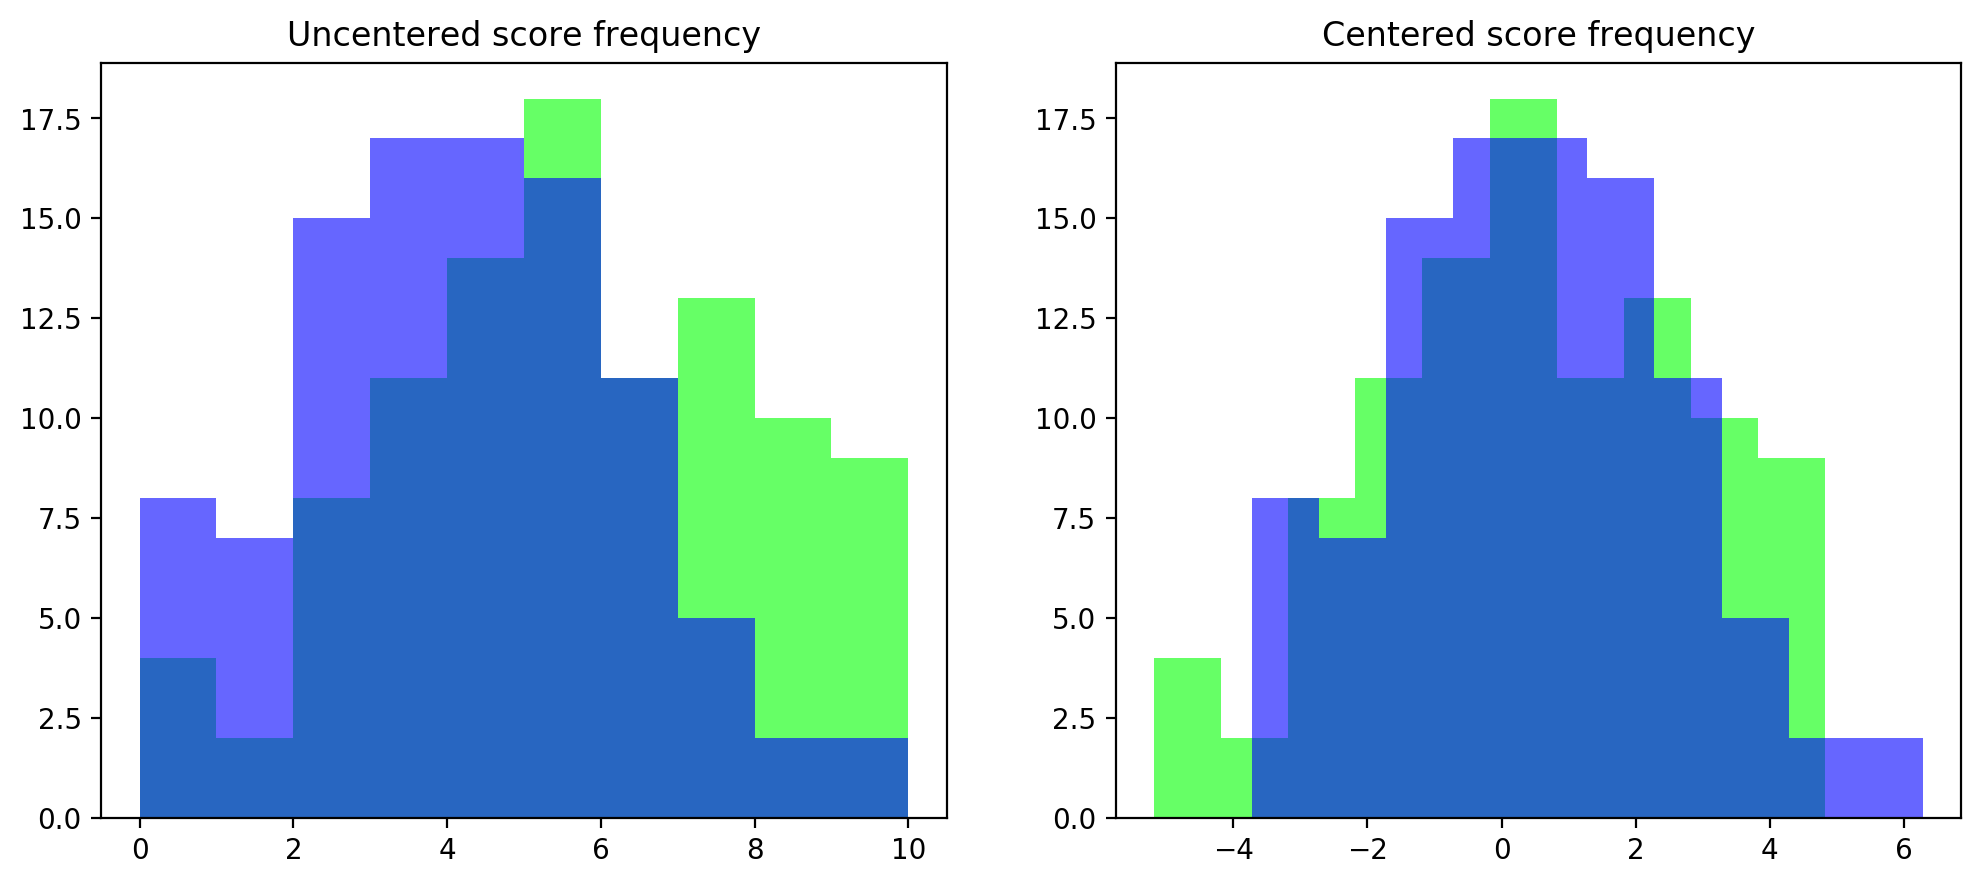

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12, 5), dpi= 200, facecolor='w', edgecolor='k' )
axes[0].hist(d_scores, bins=10, color=(0,1,0,.6))
axes[0].hist(z_scores, bins=10, color=(0,0,1,.6))
axes[0].set_title("Uncentered score frequency")
axes[1].hist(d_centered, bins=10, color=(0,1,0,.6))
axes[1].hist(z_centered, bins=10, color=(0,0,1,.6))
axes[1].set_title("Centered score frequency")

In [56]:
d = pd.read_csv("data/drew-annotations.csv")[:100][['body_text', 'support_rating']]
z = pd.read_csv("data/zach-annotations.csv")[:100][['body_text', 'support_rating']]
compare = d.copy().rename(columns={'body_text': "text", 'support_rating': "rating_d"})
compare['rating_z'] = z['support_rating']
compare['d'] = abs(compare.rating_d - compare.rating_z)
disagreements = compare.sort_values(by=['d'], ascending=False)[compare.d > 4]

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [57]:
for i, d in disagreements.iterrows():
    print(f"Disagreement by {d.d}:\n{d.text}\n")

Disagreement by 7.0:
Hi Rita, Although I do not know you, I have had the privilege of meeting your daughter Brandi and your granddaughter Allie. I have no doubt that you are an amazing woman, as you have raised such beautiful, caring daughter! My daughter, Rylee goes to school with Allie and they are in gymnastics together. Allie has been such a wonderful friend to Rylee and I know that Rylee really looks up to her! My husband, Jeremy, was recently diagnosed with a very aggressive form of Non Hodgkin's Lymphoma. As I'm sure all that care about you can attest, it is really hard to watch the ones we love have to go through something so difficult, but you guys are such an inspiration to all of us!!! May God bless you and give you the strength you need to fight your cancer! May He also watch over your family during this struggle!

Disagreement by 6.0:
love you little man i hope you and your family have a great Christmas!! had a great day with all of you love Aunt Tara

Disagreement by 6.0:

### Agreement with Model

In [3]:
gbs = pd.read_hdf('data/classified_gbs.h5', key='gbs')
len(gbs)

1000000

In [4]:
gbs.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction,body_text,tokens,pred_label,pred_prob_neutral,pred_prob_supportive,support_discretized
540271,355936,11900,guestbook,1184103659000,1184103659000,,-1.0,True,False,"For all the help the medical community can be,...","[For, all, the, help, the, medical, community,...",1,0.331490,0.668510,False
3609373,1884841,119180,guestbook,1251075969000,1251075969000,,-1.0,True,False,Kylee: I love the story. Next time just try ...,"[Kylee, :, , I, love, the, story, ., , Nex...",1,0.232435,0.767565,True
4325045,1195944,55715,guestbook,1197856577000,1197856577000,,-1.0,True,False,What an honor to be the very first person to s...,"[What, an, honor, to, be, the, very, first, pe...",1,0.182593,0.817407,True
5414881,6773640,57152,guestbook,1301181775000,1301181775000,,-1.0,True,False,"Home is the best place to be, think about you ...","[Home, is, the, best, place, to, be, ,, think,...",0,0.584396,0.415604,False
1726463,15515585,186646,guestbook,1335786062000,1335786062000,,-1.0,True,False,I was reading the words - we can never go back...,"[I, was, reading, the, words, -, we, can, neve...",0,0.550263,0.449737,False


In [7]:
ddf = ddf[:100]; zdf = zdf[:100]; m_scores = []; m_scores_d = []; az_scores = []; ad_scores = []; sampler = 0
for user_id, site_id, body_text, d_score, z_score in zip(ddf.user_id, ddf.site_id, ddf.body_text, ddf.support_rating, zdf.support_rating):
    entry = gbs[(gbs.user_id == user_id) & (gbs.site_id == site_id) & (gbs.body_text == body_text)]
    if len(entry) != 1:
        if len(entry) == 0:
            sampler += 1 
    else:
        m_scores.extend(entry.pred_prob_supportive)
        m_scores_d.extend(round(entry.pred_prob_supportive * 10))
        az_scores.append(z_score); ad_scores.append(d_score)

In [8]:
from scipy.stats import pearsonr
dvm = pearsonr(ad_scores, m_scores)
zvm = pearsonr(az_scores, m_scores)
dvmd = pearsonr(ad_scores, m_scores_d)
zvmd = pearsonr(az_scores, m_scores_d)
print(f"[C]\n Drew: {dvm[0], dvm[1]}\n Zach: {zvm[0], zvm[1]}")
print(f"[D]\n Drew: {dvmd[0], dvmd[1]}\n Zach: {zvmd[0], zvmd[1]}")

[C]
 Drew: (0.5412068695678467, 0.009292572172557526)
 Zach: (0.1049563505887795, 0.6420456662020195)
[D]
 Drew: (0.4828387936156421, 0.022838436111757964)
 Zach: (0.13737716897163188, 0.5420967196168186)


In [30]:
avg = np.mean(np.array([[int(x) for x in ad_scores], az_scores]), axis=0)
avg 

array([3. , 4. , 3.5, 2.5, 7. , 3. , 0.5, 3.5, 5.5, 4.5, 6.5, 6.5, 2. ,
       3.5, 5.5, 4. , 4. , 4. , 4. , 5.5, 2.5, 5. ])

In [33]:
pearsonr(avg, m_scores)

(0.4495146849468804, 0.035829019621099516)